Assignment 4 - Socioeconomic analysis
===

*Due: January 17 2023*

You will analyze a set of movies dialogues and calculate their sentiment scores (using Vader, text Blob, or Naive Bayes).

Then you will analyze how the positivity (or negativity) of sentiment score expressed in movie dialogues changes through time and is affected by socioeconomic and historical events.

In particular, you will use the provided R scripts to test how sentiment scores in movies are affected by GDP per capita, Life expectancy and the political cycle (Republican or Democrat president).

## Import

In [2]:
import os
import pandas as pd
import regex as re
import contractions
import nltk
from nltk.corpus import stopwords
from textblob import TextBlob
from glob import glob
from nltk.stem import WordNetLemmatizer


lemma = WordNetLemmatizer()

stop_words = set(stopwords.words("english"))
lang = "eng"
data_path = "data/dialogs_preprocessed2/"

## Functions

### Functions for text preprocessing

In [3]:
def clean_url(input):
    output = re.sub(r"http\S+", "", input)
    return output


def fix_contraction(input):
    output = contractions.fix(input)
    return output


def clean_non_alphanumeric(input):
    output = re.sub(r"[^a-zA-Z0-9]", " ", input)
    return output


def clean_tokenization(input):
    output = nltk.word_tokenize(input)
    return output


def clean_stopwords(input):
    output = [item for item in input if item not in stop_words]
    return output


def numbers_to_words(input):
    output = []
    for item in input:
        if item.isnumeric() == True:
            output += [p.number_to_words(item)]
        else:
            output += [item]
    return output


def clean_lowercase(input):
    output = str(input).lower()
    return output


def clean_lemmatization(input):
    output = [lemma.lemmatize(word=w, pos="v") for w in input]
    return output


def clean_length(input):
    output = [word for word in input if len(word) > 2]
    return output


def convert_to_string(input):
    output = " ".join(input)
    return output


def preprocessing(text, remove_stopwords=True):
    """
    Preprocessing pipeline.
    """
    text = clean_url(text)
    text = fix_contraction(text)
    text = clean_non_alphanumeric(text)
    text = clean_lowercase(text)
    text = clean_tokenization(text)
    text = numbers_to_words(text)
    if remove_stopwords:
        text = clean_stopwords(text)
    text = clean_lemmatization(text)
    text = clean_length(text)
    text = convert_to_string(text)
    return text

## Load movie dialogs and preprocess them

In [6]:
df = pd.DataFrame(glob(data_path + "/*.txt"), columns=["movies"])
df["path"] = df["movies"]
df["movies"] = df["movies"].str.replace("^" + data_path, "", regex=True)


df["text"] = df["path"].apply(lambda path: open(path, encoding="utf-8").read())
df["text"] = df["text"].apply(lambda raw_txt: preprocessing(raw_txt))

df.head()

,movies,path,text
0,donniebrasco_dialog.txt,data/dialogs_preprocessed2/donniebrasco_dialog...,paul attanasio base book donnie brasco joseph ...
1,shiningthe_dialog.txt,data/dialogs_preprocessed2/shiningthe_dialog.txt,post production script july get appointment ul...
2,idesofmarchthe_dialog.txt,data/dialogs_preprocessed2/idesofmarchthe_dial...,write george clooney grant heslov beau willimo...
3,hangoverthe_dialog.txt,data/dialogs_preprocessed2/hangoverthe_dialog.txt,write jon lucas scott moore september word dou...
4,bringingoutthedead_dialog.txt,data/dialogs_preprocessed2/bringingoutthedead_...,first draft paul schrader novel joseph connell...


Add column for movie years

In [7]:
df_years = pd.read_csv("data/movie_years.csv", index_col=0)
df = df.merge(df_years, on="movies")

df.movies = df.movies.str.replace("_dialog.txt$", "", regex=True)

## Add sentiment scores

In [8]:
df["textblob"] = df.text.apply(lambda x: TextBlob(x).sentiment.polarity)

df.head()

,movies,path,text,year,textblob
0,donniebrasco,data/dialogs_preprocessed2/donniebrasco_dialog...,paul attanasio base book donnie brasco joseph ...,1997,-0.011833
1,shiningthe,data/dialogs_preprocessed2/shiningthe_dialog.txt,post production script july get appointment ul...,1980,0.158831
2,idesofmarchthe,data/dialogs_preprocessed2/idesofmarchthe_dial...,write george clooney grant heslov beau willimo...,2011,0.097131
3,hangoverthe,data/dialogs_preprocessed2/hangoverthe_dialog.txt,write jon lucas scott moore september word dou...,2009,0.156580
4,bringingoutthedead,data/dialogs_preprocessed2/bringingoutthedead_...,first draft paul schrader novel joseph connell...,1999,0.013822


Save dataframe

In [9]:
df.to_csv("data/assignment_4_sentiment_scores.csv", index=False)

Load dataframe

In [10]:
df = pd.read_csv("data/assignment_4_sentiment_scores.csv")

df.head()

,movies,path,text,year,textblob
0,donniebrasco,data/dialogs_preprocessed2/donniebrasco_dialog...,paul attanasio base book donnie brasco joseph ...,1997,-0.011833
1,shiningthe,data/dialogs_preprocessed2/shiningthe_dialog.txt,post production script july get appointment ul...,1980,0.158831
2,idesofmarchthe,data/dialogs_preprocessed2/idesofmarchthe_dial...,write george clooney grant heslov beau willimo...,2011,0.097131
3,hangoverthe,data/dialogs_preprocessed2/hangoverthe_dialog.txt,write jon lucas scott moore september word dou...,2009,0.156580
4,bringingoutthedead,data/dialogs_preprocessed2/bringingoutthedead_...,first draft paul schrader novel joseph connell...,1999,0.013822


## Time series

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress


df_clean = df.copy().dropna()

reg = linregress(df_clean.year, df_clean.textblob)

print("Regression result:\n")
print("intercept:", reg.intercept)
print("slope:", reg.slope)
print("p:", reg.pvalue)

Regression result:

intercept: 1.2071145932778309
slope: -0.0005662637149927922
p: 0.0003142990348951341


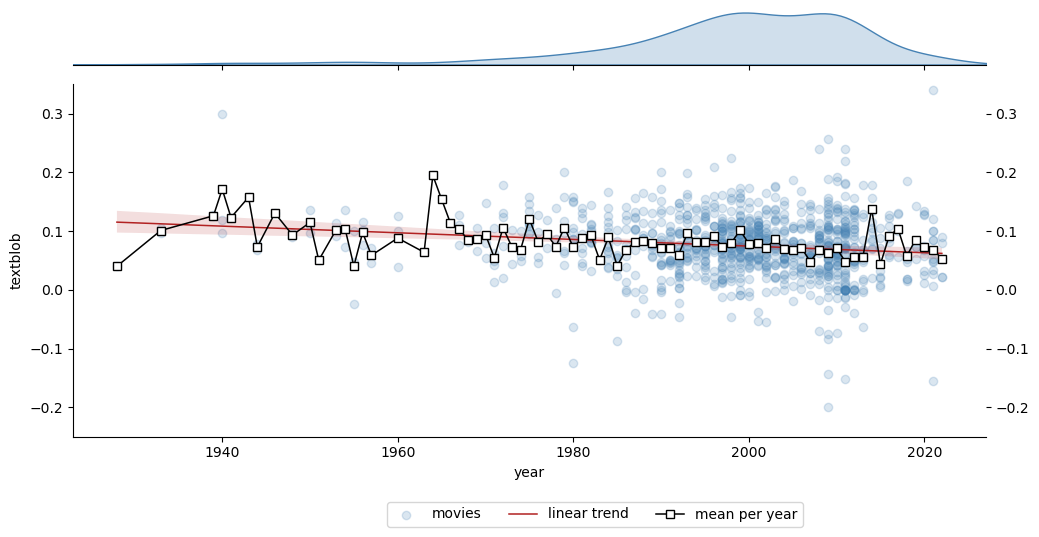

In [403]:
g = sns.JointGrid(
    x=df.year,
    y=df.textblob,
    ylim=(-0.25, 0.35),
    xlim=(-5 + min(df.year), 5 + max(df.year)),
)

regplot = g.plot_joint(
    sns.regplot,
    scatter_kws=dict(alpha=0.2, color="steelblue"),
    line_kws=dict(color="firebrick", lw=1.1, label="linear trend", linestyle="-"),
    label="movies",
)

g.plot_marginals(sns.kdeplot, fill=True, color="steelblue")
g.ax_marg_y.set_visible(False)

g.fig.figure.set_figheight(5)
g.fig.figure.set_figwidth(12)

palette = sns.color_palette(["black"])

lplot = sns.lineplot(
    df_clean.groupby("year").mean(),
    lw=1.1,
    marker="s",
    markersize=6,
    markeredgecolor="black",
    markeredgewidth=1,
    markerfacecolor="white",
    ax=g.ax_joint,
    palette=palette,
    label="mean per year",
    legend=False,
)
g.ax_joint.tick_params(right=True, labelright=True, grid_color="black")
g.fig.legend(loc="upper center", bbox_to_anchor=(0.5, 0), ncol=3)
g.fig.tight_layout();

<div class="alert alert-info">Significant probably only because of the large number of datapoints. Is the effect actually relevant?</div>